In [1]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot


import scipy
import awkward as ak
import time
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import L1_trg, deltaPhi

import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [2]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()

# for data_year in ['2022','2023','all']:
for data_year in ['all']:

    # path = "/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/data/raw/"
    # fpath_bkg[data_year] = path + f"data_{data_year}_goodLumi.root"
    if data_year == 'all':path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/'
    else: path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data{data_year}/v14/normalized/'
    if data_year == '2022':fpath['data'+data_year] = path + "DisplacedJet-EXOCSCCluster_Run2022-PromptReco_goodLumi.root"
    elif data_year == '2023':fpath['data'+data_year] = path + "Muon-EXOCSCCluster_Run2023-PromptReco_goodLumi.root"
    elif data_year == 'all':fpath['data'+data_year] = path + "EXOCSCCluster_Run2022_2023_goodLumi.root"

fpath['sig'] = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root'
NEvents = {}

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'].values()[0]
    # NEvents[k] = root_dir['NEvents'].counts()
    print("NEvents",NEvents[k])


dataall /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/EXOCSCCluster_Run2022_2023_goodLumi.root
NEvents 34804216.0
sig /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57555044.0
CPU times: user 390 ms, sys: 7.48 ms, total: 398 ms
Wall time: 403 ms


In [3]:
def HLT_CSC(eta,nstation,size):
    size_threshold = np.zeros(eta.shape)
    
    size_threshold[(nstation == 1) & (np.abs(eta)<1.9)] = 200
    size_threshold[(nstation == 1) & (np.abs(eta)>1.9)] = 500
    size_threshold[(nstation > 1) & (np.abs(eta)<1.9)] = 100
    size_threshold[(nstation > 1) & (np.abs(eta)>1.9)] = 500
    return (size > size_threshold)

# apply selections

In [3]:
%%time


JET_PT_CUT = 30
MUON_PT_CUT = 30.0
N_RECHIT_CUT = 90

cscRechitClusterPhi0 = {}
cscRechitClusterPhi1 = {}
deltaPhi_cluster  = {}
cscRechitClusterDNN0  = {}
cscRechitClusterDNN1  = {}
cscRechitClusterTime0  = {}
cscRechitClusterTime1  = {}
cscRechitClusterSize0  = {}
cscRechitClusterSize1  = {}


region_list = ['invertDNN', 'oot', 'signal']
for region in region_list:
    for tree_k in tree.keys():
    #     if not k=='data_intime_BDTbin1': continue
        T = tree[tree_k]
        k = f'{region}_{tree_k}'


    ########### SELECTION: CLUSTERS ############
        me1 = (T['cscRechitClusterNRechitChamberPlus11'].array()+ T['cscRechitClusterNRechitChamberPlus12'].array()+\
        T['cscRechitClusterNRechitChamberMinus11'].array()+ T['cscRechitClusterNRechitChamberMinus12'].array())
        cscRechitClusterR = (T['cscRechitClusterX'].array()**2+T['cscRechitClusterY'].array()**2)**0.5
        L1 = L1_trg(cscRechitClusterR, np.abs(T['cscRechitClusterZ'].array()), np.abs(T['cscRechitClusterSize'].array()))

        #one cluster to pass trigger
        cluster0 = np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, T['cscRechitClusterTimeWeighted'].array() > -5)
        # cluster0 = cluster0 & L1
        cluster0 = cluster0 & (me1 ==0)
        cluster0 = cluster0 & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster0 = cluster0 & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster0 = cluster0 & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    


        cluster1 = (me1 == 0)
        cluster1 = cluster1 & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster1 = cluster1 & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster1 = cluster1 & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    
        # if 'oot' in region: cluster1 = cluster1 & (T['cscRechitClusterTimeWeighted'].array() < -12.5)
        # else:cluster1 = cluster1 & (T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array() < 0.96)



    ########### SELECTION: EVENTS ############
        sel_ev = T['HLT_CSCCSC'].array()
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster0, axis = 1) >= 1)
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster1, axis = 1) == 2)
        
        
        # if met_cat == 'lowMET':sel_ev = np.logical_and(sel_ev ,T['met'].array() < 150)
        # else: sel_ev = sel_ev & (T['met'].array() > 150) & (T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev ,T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev,T['nCscRechitClusters'].array()==2)
        # print(np.count_nonzero(temp), np.count_nonzero(sel_ev))

    ########### BRANCHES ############

       ##### event variables ##### 
        # make sure cluster0 and cluster1 index are different
        cluster1 = cluster1[sel_ev]
        cluster0 = cluster0[sel_ev]

        #remove cluster0 from cluster1 selection to make sure we select different clusters
        cluster0_index = list(np.argmax(cluster0, axis=1))
        cluster0_mask = ak.Array([[False if j == cluster0_index[i] else True for j in range(len(cluster1[i]))] for i in range(len(cluster1))])
        cluster1 = cluster0_mask & cluster1
                
        cscRechitClusterPhi0[k] = T['cscRechitClusterPhi'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterPhi1[k] = T['cscRechitClusterPhi'].array()[sel_ev][cluster1][:,0]
        deltaPhi_cluster[k] = deltaPhi(np.array(cscRechitClusterPhi0[k]), np.array(cscRechitClusterPhi1[k]))
        cscRechitClusterDNN0[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterDNN1[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[sel_ev][cluster1][:,0]
        cscRechitClusterTime0[k] = T['cscRechitClusterTimeWeighted'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterTime1[k] = T['cscRechitClusterTimeWeighted'].array()[sel_ev][cluster1][:,0]
        cscRechitClusterSize0[k] = T['cscRechitClusterSize'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterSize1[k] = T['cscRechitClusterSize'].array()[sel_ev][cluster1][:,0]
        
        sel = (np.abs(deltaPhi_cluster[k])>1.8)
        if 'oot' in region:
            sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] > 0.96) & (cscRechitClusterTime1[k]<-12.5)
        elif 'invertDNN' in region:
            sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] < 0.96) \
            & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        elif 'signal' in region:
            sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] > 0.96) \
            & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        else: assert(False)
            
        deltaPhi_cluster[k] = deltaPhi_cluster[k][sel]
        cscRechitClusterSize1[k] = cscRechitClusterSize1[k][sel]
        print("correlation between two variables:", k, scipy.stats.pearsonr(deltaPhi_cluster[k], cscRechitClusterSize1[k]))
        print("events in this region:", k, len(deltaPhi_cluster[k]))

correlation between two variables: invertDNN_dataall (-0.013189681108034541, 0.7663543003245654)
events in this region: invertDNN_dataall 510
correlation between two variables: invertDNN_sig (0.08841484119648836, 0.10261864414109327)
events in this region: invertDNN_sig 342
correlation between two variables: oot_dataall (-0.003822248661944534, 0.94119284776451)
events in this region: oot_dataall 375
correlation between two variables: oot_sig (0.20525068556755371, 0.8683980629643594)
events in this region: oot_sig 3
correlation between two variables: signal_dataall (0.06172041871091932, 0.42258514504589834)
events in this region: signal_dataall 171
correlation between two variables: signal_sig (-0.004952960303296888, 0.827328993314127)
events in this region: signal_sig 1942
CPU times: user 1min, sys: 4.73 s, total: 1min 4s
Wall time: 1min 4s


# distribution of dphi and Nrechits

invertDNN_2022 199.0 199
invertDNN_2023 405.0 405
invertDNN_all 604.0 604
invertDNN_sig 324.0 356
oot_2022 139.0 139
oot_2023 308.0 308
oot_all 447.0 447
oot_sig 3.0 3
1.8342797756195068


Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_2022.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_2022.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_2022.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_2023.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_2023.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw

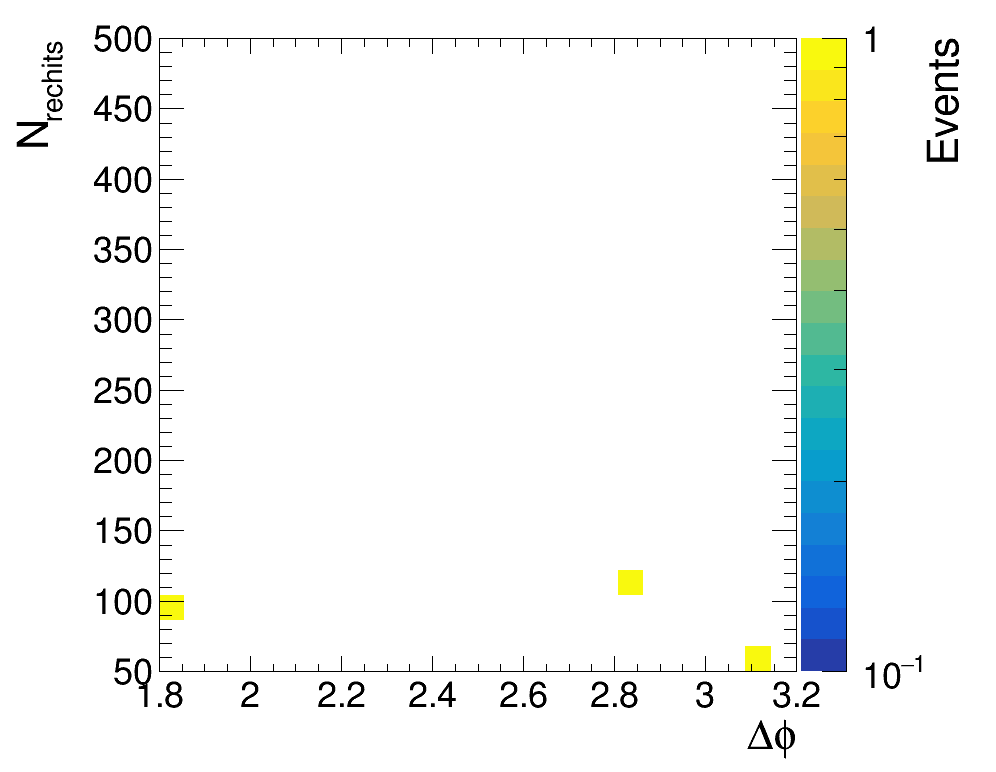

In [4]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)

for k in cscRechitClusterSize1.keys():
    # h = create_TH2D(np.column_stack(( np.array(cscRechitClusterSize1[k]), np.abs(deltaPhi_cluster[k]))),
                   # axis_title = ['N_{rechits}','#Delta#phi','Events'], binning=[25,50,500,25,1.8,3.2])
    
    h = create_TH2D(np.column_stack(( np.abs(deltaPhi_cluster[k]), np.array(cscRechitClusterSize1[k]), )),
                   axis_title = ['#Delta#phi','N_{rechits}','Events'], binning=[25,1.8,3.2,25,50,500,])

    h.SetMinimum(0.1)
    h.Draw('colz')
    c.SetRightMargin(0.2)

    print(k, h.Integral(), len(cscRechitClusterSize1[k]))
    # if setlog: 
    c.SetLogz()
    c.Draw()

    c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+k+".png")
    c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+k+".pdf")
    c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+k+".C")
    



print(time.time()-start_t)

# ABCD (Scan Nrechits)

In [14]:
a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(60,300,10)
# cuts = np.arange(90,150,1)
n_ev = 5000


# cuts = [90,95,100,104,105]
print(cuts)
bkg_dphiJet = []
sig_dphiJet = []
bkg_dphiCluster = []
sig_dphiCluster = []
print_jetmet = 0
DPHI_CUT = 2.8

for k in cscRechitClusterSize1.keys():
    if "sig" in k:continue
    print("*****************************")
    print(f"******** {k} **********")
    print("*****************************")
    for N_RECHIT_CUT in cuts:
        if N_RECHIT_CUT<100:continue
        var = np.abs(deltaPhi_cluster[k])
        
        a[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
        c[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var>=DPHI_CUT)])


        if b[k] == 0 or c[k] == 0 or d[k] ==0:break
        pred = b[k]*d[k]/c[k]
        unc_pred = (1./c[k] + 1./b[k] + 1./d[k])**0.5*pred
        if math.isnan(unc_pred): z_value = float("nan")
        else:
            mu = np.random.normal(pred, unc_pred, n_ev)
            p_value = 0.0
            for i in mu:
                if i < 0:continue
                n = np.random.poisson(i, n_ev)
                p_value += np.count_nonzero(n>=a[k])

            p_value = p_value/n_ev**2
            z_value = abs(norm.ppf(p_value))
        print(N_RECHIT_CUT, '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              round( unc_pred, 2), '\t', round(z_value,2))



[ 60  70  80  90 100 110 120 130 140 150 160 170 180 190 200 210 220 230
 240 250 260 270 280 290]
*****************************
******** invertDNN_dataall **********
*****************************
100 	 12 	 44 	 326 	 128 	 17.28 	 3.17 	 1.13
110 	 11 	 32 	 338 	 129 	 12.21 	 2.5 	 0.35
120 	 10 	 24 	 346 	 130 	 9.02 	 2.06 	 0.2
130 	 8 	 17 	 353 	 132 	 6.36 	 1.67 	 0.47
140 	 7 	 12 	 358 	 133 	 4.46 	 1.36 	 0.86
150 	 6 	 8 	 362 	 134 	 2.96 	 1.09 	 1.2
160 	 5 	 5 	 365 	 135 	 1.85 	 0.85 	 1.49
170 	 5 	 5 	 365 	 135 	 1.85 	 0.85 	 1.5
180 	 5 	 4 	 366 	 135 	 1.48 	 0.75 	 1.8
190 	 2 	 4 	 366 	 138 	 1.51 	 0.77 	 0.19
200 	 2 	 3 	 367 	 138 	 1.13 	 0.66 	 0.48
210 	 1 	 2 	 368 	 139 	 0.76 	 0.54 	 0.05
220 	 1 	 2 	 368 	 139 	 0.76 	 0.54 	 0.05
230 	 0 	 1 	 369 	 140 	 0.38 	 0.38 	 0.99
240 	 0 	 1 	 369 	 140 	 0.38 	 0.38 	 1.02
250 	 0 	 1 	 369 	 140 	 0.38 	 0.38 	 1.05
260 	 0 	 1 	 369 	 140 	 0.38 	 0.38 	 0.98
270 	 0 	 1 	 369 	 140 	 0.38 	 

# ABCD (Scan dPhi)

In [16]:

a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(0,35,2)/10
cuts = np.arange(1.8,3.2,0.05)
print(cuts)
n_ev = 5000


N_RECHIT_CUT = 190
for k in cscRechitClusterSize1.keys():
    if "sig" in k:continue
    print("*****************************")
    print(f"******** {k} **********")
    print("*****************************")
    for DPHI_CUT in cuts:
        var = np.abs(deltaPhi_cluster[k])
        
        a[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
        c[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var>=DPHI_CUT)])


        if b[k] == 0 or c[k] == 0 or d[k] ==0:continue
        pred = b[k]*d[k]/c[k]
        unc_pred = (1./c[k] + 1./b[k] + 1./d[k])**0.5*pred
        if math.isnan(unc_pred): z_value = float("nan")
        else:
            mu = np.random.normal(pred, unc_pred, n_ev)
            p_value = 0.0
            for i in mu:
                if i < 0:continue
                n = np.random.poisson(i, n_ev)
                p_value += np.count_nonzero(n>=a[k])

            p_value = p_value/n_ev**2
            z_value = abs(norm.ppf(p_value))
        print(round(DPHI_CUT,2), '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              round( unc_pred, 2), '\t', round(z_value,2))

 

[1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45
 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15]
*****************************
******** invertDNN_dataall **********
*****************************
1.85 	 4 	 2 	 19 	 485 	 51.05 	 38.02 	 1.24
1.9 	 4 	 2 	 32 	 472 	 29.5 	 21.54 	 1.21
1.95 	 4 	 2 	 53 	 451 	 17.02 	 12.29 	 1.06
2.0 	 4 	 2 	 72 	 432 	 12.0 	 8.62 	 0.89
2.05 	 4 	 2 	 92 	 412 	 8.96 	 6.42 	 0.74
2.1 	 4 	 2 	 114 	 390 	 6.84 	 4.89 	 0.52
2.15 	 4 	 2 	 136 	 368 	 5.41 	 3.87 	 0.33
2.2 	 4 	 2 	 153 	 351 	 4.59 	 3.27 	 0.17
2.25 	 4 	 2 	 166 	 338 	 4.07 	 2.91 	 0.04
2.3 	 4 	 2 	 184 	 320 	 3.48 	 2.48 	 0.15
2.35 	 3 	 3 	 191 	 313 	 4.92 	 2.87 	 0.62
2.4 	 3 	 3 	 208 	 296 	 4.27 	 2.49 	 0.44
2.45 	 3 	 3 	 227 	 277 	 3.66 	 2.14 	 0.28
2.5 	 3 	 3 	 251 	 253 	 3.02 	 1.77 	 0.05
2.55 	 3 	 3 	 279 	 225 	 2.42 	 1.41 	 0.19
2.6 	 3 	 3 	 298 	 206 	 2.07 	 1.21 	 0.37
2.65 	 2 	 4 	 317 	 187 	 2.36

In [ ]:
# Optimization
